# Assignment: Data Wrangling
### `! git clone https://github.com/ds3001f25/wrangling_assignment.git`
### Do Q1 and Q2
### Reading material: `tidy_data.pdf`

In [28]:
! git clone https://github.com/ds3001f25/wrangling_assignment.git

fatal: destination path 'wrangling_assignment' already exists and is not an empty directory.


**Q1.** This question provides some practice cleaning variables which have common problems.
1. Numeric variable: For `./data/airbnb_hw.csv`, clean the `Price` variable as well as you can, and explain the choices you make. How many missing values do you end up with? (Hint: What happens to the formatting when a price goes over 999 dollars, say from 675 to 1,112?)
2. Categorical variable: For the Minnesota police use of for data, `./data/mn_police_use_of_force.csv`, clean the `subject_injury` variable, handling the NA's; this gives a value `Yes` when a person was injured by police, and `No` when no injury occurred. What proportion of the values are missing? Is this a concern? Cross-tabulate your cleaned `subject_injury` variable with the `force_type` variable. Are there any patterns regarding when the data are missing?
3. Dummy variable: For the pretrial data covered in the lecture `./data/justice_data.parquet`, clean the `WhetherDefendantWasReleasedPretrial` variable as well as you can, and, in particular, replace missing values with `np.nan`.
4. Missing values, not at random: For the pretrial data covered in the lecture, clean the `ImposedSentenceAllChargeInContactEvent` variable as well as you can, and explain the choices you make. (Hint: Look at the `SentenceTypeAllChargesAtConvictionInContactEvent` variable.)

In [27]:
from pickle import FALSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# loading data

airbnb = pd.read_csv("wrangling_assignment/data/airbnb_hw.csv", low_memory=False)
mn_police = pd.read_csv("wrangling_assignment/data/mn_police_use_of_force.csv", low_memory=False)
justice = pd.read_parquet("wrangling_assignment/data/justice_data.parquet", low_memory=False)


#1.

print(airbnb["Price"].head(10))

airbnb["Price_clean"] = (
    airbnb["Price"]
    .replace('[\\$,]', '', regex=True)   # remove $ and commas
    .astype(float)                      # convert to float
)

# Count missing
print("Missing values:", airbnb["Price_clean"].isna().sum())

mn_police = pd.read_csv("wrangling_assignment/data/mn_police_use_of_force.csv")

# Standardize to Yes / No
mn_police["subject_injury_clean"] = (
    mn_police["subject_injury"]
    .str.strip().str.lower()
    .map({"yes": "Yes", "no": "No"})
)

# Missing proportion
missing_injury = mn_police["subject_injury_clean"].isna().mean()
print("Proportion missing:", round(missing_injury, 3))

# Cross-tab with force_type
ct = pd.crosstab(mn_police["subject_injury_clean"], mn_police["force_type"])
print(ct)

justice = pd.read_parquet("wrangling_assignment/data/justice_data.parquet")

justice["ReleasedPretrial_clean"] = (
    justice["WhetherDefendantWasReleasedPretrial"]
    .map({"Yes": 1, "No": 0})
)

# Ensure missing values stay np.nan
justice["ReleasedPretrial_clean"] = justice["ReleasedPretrial_clean"].where(
    pd.notnull(justice["ReleasedPretrial_clean"]), np.nan
)

# Explore relationship
pd.crosstab(
    justice["SentenceTypeAllChargesAtConvictionInContactEvent"].fillna("No Conviction"),
    justice["ImposedSentenceAllChargeInContactEvent"].isna()
)

# Clean
justice["Sentence_clean"] = justice["ImposedSentenceAllChargeInContactEvent"]

# If convicted but missing sentence → mark as "Unknown"
convicted = justice["SentenceTypeAllChargesAtConvictionInContactEvent"].notna()
justice.loc[convicted & justice["Sentence_clean"].isna(), "Sentence_clean"] = "Unknown"


0    145
1     37
2     28
3    199
4    549
5    149
6    250
7     90
8    270
9    290
Name: Price, dtype: object
Missing values: 0
Proportion missing: 0.762
force_type            Baton  Bodily Force  Chemical Irritant  Firearm  \
subject_injury_clean                                                    
No                        0          1093                131        2   
Yes                       2          1286                 41        0   

force_type            Gun Point Display  Improvised Weapon  \
subject_injury_clean                                         
No                                   33                 34   
Yes                                  44                 40   

force_type            Less Lethal Projectile  Police K9 Bite  Taser  
subject_injury_clean                                                 
No                                         1               2    150  
Yes                                        2              44    172  


**Q2.** Go to https://sharkattackfile.net/ and download their dataset on shark attacks (Hint: `GSAF5.xls`).

1. Open the shark attack file using Pandas. It is probably not a csv file, so `read_csv` won't work.
2. Drop any columns that do not contain data.
3. Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?
4. Clean the Age variable and make a histogram of the ages of the victims.
5. What proportion of victims are male?
6. Clean the `Type` variable so it only takes three values: Provoked and Unprovoked and Unknown. What proportion of attacks are unprovoked?
7. Clean the `Fatal Y/N` variable so it only takes three values: Y, N, and Unknown.
8. Are sharks more likely to launch unprovoked attacks on men or women? Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Is it more or less likely to be fatal when the victim is male or female? How do you feel about sharks?
9. What proportion of attacks appear to be by white sharks? (Hint: `str.split()` makes a vector of text values into a list of lists, split by spaces.)

Saving GSAF5.xls to GSAF5.xls
(7042, 23)
Year range: 0.0 - 2026.0


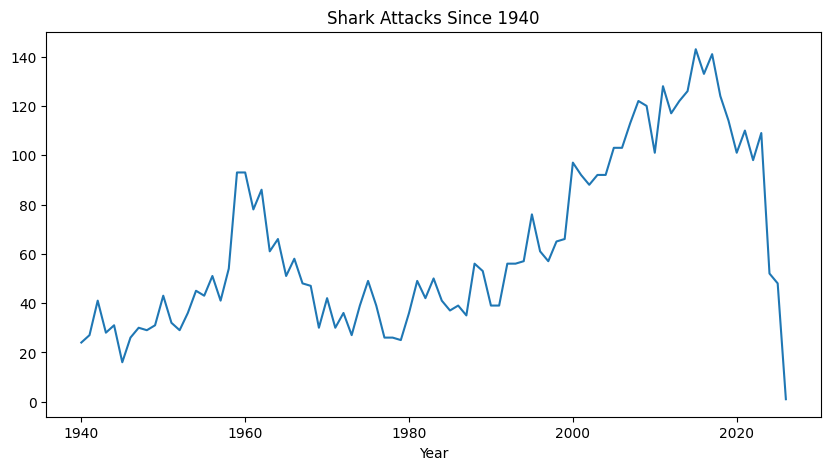

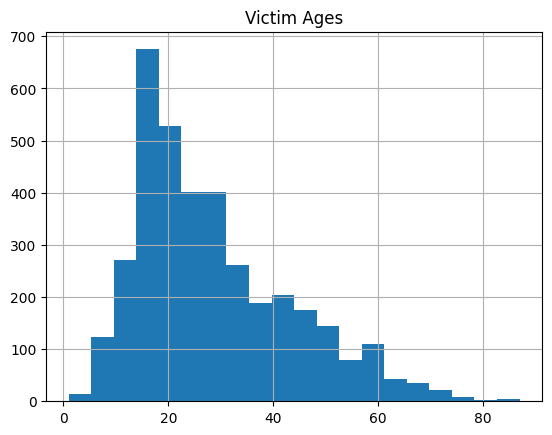

Proportion male victims: 0.7860904303613583
Type_clean
Unprovoked    0.744144
Unknown       0.161794
Provoked      0.094062
Name: proportion, dtype: float64


KeyError: 'Fatal (Y/N)'

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

# Load Excel, don't overwrite the file
df = pd.read_excel("GSAF5.xls")

print(df.shape)
df.head()

df = df.dropna(axis=1, how="all")
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

print("Year range:", df["Year"].min(), "-", df["Year"].max())

# Keep only >= 1940
df = df[df["Year"] >= 1940]

# Plot counts
df["Year"].value_counts().sort_index().plot(kind="line", figsize=(10,5))
plt.title("Shark Attacks Since 1940")
plt.show()

df["Age_clean"] = pd.to_numeric(
    df["Age"].astype(str).str.extract(r"(\d{1,2})")[0],
    errors="coerce"
)

df["Age_clean"].hist(bins=20)
plt.title("Victim Ages")
plt.show()

df["Sex_clean"] = df["Sex"].str.upper().map({"M":"M","F":"F"})
male_prop = (df["Sex_clean"]=="M").mean()
print("Proportion male victims:", male_prop)


df["Type_clean"] = df["Type"].str.capitalize()
df["Type_clean"] = df["Type_clean"].where(
    df["Type_clean"].isin(["Provoked","Unprovoked"]),
    "Unknown"
)
print(df["Type_clean"].value_counts(normalize=True))


df["Fatal_clean"] = df["Fatal (Y/N)"].str.upper().map({"Y":"Y","N":"N"})
df["Fatal_clean"] = df["Fatal_clean"].fillna("Unknown")
print(df["Fatal_clean"].value_counts(normalize=True))

# Unprovoked by gender
print(pd.crosstab(df["Sex_clean"], df["Type_clean"], normalize="index"))

# Fatality by Type
print(pd.crosstab(df["Fatal_clean"], df["Type_clean"], normalize="columns"))

# Fatality by Sex
print(pd.crosstab(df["Fatal_clean"], df["Sex_clean"], normalize))

df["Species"] = df["Species"].astype(str).str.lower()
white_prop = df["Species"].str.contains("white").mean()
print("Proportion white sharks:", white_prop)







